# Project Statement

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Introduction

In this project, we delve into the automotive industry's dynamic realm, focusing on Rusty Bargain's venture to enhance customer engagement through predictive analytics. Our primary goal is to construct a model capable of accurately estimating used car values, leveraging a rich dataset of vehicle specifications and historical pricing. This project leverages advanced data science to enhance the prediction of used car values. By analyzing a comprehensive dataset, this initiative aims to refine the approach to car valuation.

## Objectives:

- Model Exploration: Investigate various machine learning models to identify the optimal approach for accurate and efficient car price predictions.

- Data Preparation and Preprocessing: Ensure the dataset is meticulously prepared for analysis, focusing on encoding categorical variables and normalizing numerical data to facilitate model training.

- Hyperparameter Optimization: Undertake model parameter tuning to maximize predictive accuracy, focusing on evaluating different configurations to enhance model performance.

In [25]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from time import time

In [26]:
# Load the data
try:
    df = pd.read_csv('./datasets/car_data.csv')
except:
    df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv')


# Data preparation

In [27]:

df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
329779,26/03/2016 18:50,3500,sedan,2002,auto,125,a3,150000,8,petrol,audi,no,26/03/2016 00:00,0,52152,07/04/2016 14:56
152520,28/03/2016 15:40,400,NaN,1997,NaN,0,NaN,100000,10,petrol,fiat,yes,28/03/2016 00:00,0,95326,30/03/2016 06:18
341270,24/03/2016 18:49,7700,coupe,2003,manual,170,3er,150000,5,petrol,bmw,no,24/03/2016 00:00,0,42119,07/04/2016 13:15
112944,25/03/2016 13:38,6850,small,2008,manual,75,500,80000,10,gasoline,fiat,no,25/03/2016 00:00,0,66780,28/03/2016 12:45
32646,19/03/2016 21:36,1250,suv,1990,manual,69,other,100000,7,petrol,suzuki,no,19/03/2016 00:00,0,21481,23/03/2016 13:19
189439,24/03/2016 10:37,15450,wagon,2009,manual,160,a4,90000,4,petrol,audi,no,24/03/2016 00:00,0,77704,07/04/2016 02:15
154888,20/03/2016 21:55,13990,wagon,2009,auto,224,c_klasse,150000,1,gasoline,mercedes_benz,no,20/03/2016 00:00,0,13407,22/03/2016 01:45
224257,04/04/2016 19:41,300,small,1998,manual,55,NaN,150000,11,petrol,opel,NaN,04/04/2016 00:00,0,7545,04/04/2016 19:41
175011,25/03/2016 15:55,5500,wagon,2006,auto,163,3er,150000,10,gasoline,bmw,no,25/03/2016 00:00,0,4158,06/04/2016 20:16
45025,07/03/2016 20:45,0,small,1997,manual,45,polo,150000,7,petrol,volkswagen,NaN,07/03/2016 00:00,0,49453,26/03/2016 06:45


In [28]:
df.isna().sum().sort_values(ascending=False)


NotRepaired          71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Mileage                  0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [29]:
# Initial count of records in df
initial_count = len(df)

missing_values = df.isnull().sum()
percent_missing = (df.isnull().sum() / len(df) * 100).round(2)

# Combine into a DataFrame
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': percent_missing})
missing_df = missing_df.sort_values('Percentage', ascending=False)

# Function to color the values
def color_missing_values(val):
    """
    Colors elements in a dateframe
    green if the percentage of missing values is 0,
    yellow if the percentage is between 0 and 10,
    and red if above 10.
    """
    color = 'green' if val == 0 else 'yellow' if val <= 10 else 'red'
    return f'background-color: {color}'

# Apply the styling
styled_df = missing_df.style.applymap(color_missing_values, subset=['Percentage']) \
                            .format({'Percentage': '{:.2f}%'})

styled_df

,Missing Values,Percentage
NotRepaired,71154,20.08%
VehicleType,37490,10.58%
FuelType,32895,9.28%
Gearbox,19833,5.60%
Model,19705,5.56%
DateCrawled,0,0.00%
Price,0,0.00%
RegistrationYear,0,0.00%
Power,0,0.00%
Mileage,0,0.00%


In [30]:
duplicates = df.duplicated(keep=False)
display(df.loc[duplicates].sort_values(['DateCrawled']))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90786,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
87112,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
45825,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
142496,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
12578,01/04/2016 12:57,1499,wagon,1995,manual,150,5er,150000,6,petrol,bmw,no,01/04/2016 00:00,0,25821,07/04/2016 09:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68628,31/03/2016 19:51,999,small,1998,manual,60,corsa,150000,5,petrol,opel,no,31/03/2016 00:00,0,85111,06/04/2016 14:18
228351,31/03/2016 20:25,9600,sedan,2006,manual,226,focus,125000,4,petrol,ford,no,31/03/2016 00:00,0,55469,06/04/2016 14:15
27192,31/03/2016 20:25,9600,sedan,2006,manual,226,focus,125000,4,petrol,ford,no,31/03/2016 00:00,0,55469,06/04/2016 14:15
30499,31/03/2016 23:51,5999,wagon,2007,manual,120,astra,150000,3,gasoline,opel,no,31/03/2016 00:00,0,95482,07/04/2016 00:17


In [31]:
# Check and remove duplicates
initial_row_count = df.shape[0]
duplicated_count = df.duplicated().sum()
# Remove duplicates, keeping the first occurrence
df = df.drop_duplicates(keep='first')
# Reset the index
df.reset_index(drop=True, inplace=True)
final_row_count = df.shape[0]

# Print Results
print(f"Initial number of rows: {initial_row_count}")
print(f"Number of duplicated rows removed: {duplicated_count}")
print(f"Number of rows after removal: {final_row_count}")

Initial number of rows: 354369
Number of duplicated rows removed: 262
Number of rows after removal: 354107


Based on the examination of the dataset, it is observed that there are duplicate entries where all attributes, including dates and vehicle specifics, are identical between records. This lack of distinction suggests that these duplicates do not represent unique vehicle listings but are rather unintentional repetitions of the same data entry. Given this redundancy, removing these duplicate entries is a prudent step in data cleaning to ensure the integrity and accuracy of subsequent analyses. By eliminating these duplicates, we can avoid potential biases or inaccuracies in the model's training and evaluation phases, leading to a more reliable and valid assessment of vehicle market values.

In [32]:
# Convert column names to lowercase
df.columns = ['date_crawled', 
              'price', 
              'vehicle_type',
              'registration_year',
              'gearbox',
              'power',
              'model',
              'mileage',
              'registration_month',
              'fuel_type',
              'brand',
              'not_repaired',
              'date_created',
              'number_of_pictures',
              'postal_code',
              'last_seen']

In [33]:
# Convert date columns to datetime format
date_columns = ['date_crawled', 'date_created', 'last_seen']
df[date_columns] = df[date_columns].apply(pd.to_datetime, format="%d/%m/%Y %H:%M")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354107 non-null  datetime64[ns]
 1   price               354107 non-null  int64         
 2   vehicle_type        316623 non-null  object        
 3   registration_year   354107 non-null  int64         
 4   gearbox             334277 non-null  object        
 5   power               354107 non-null  int64         
 6   model               334406 non-null  object        
 7   mileage             354107 non-null  int64         
 8   registration_month  354107 non-null  int64         
 9   fuel_type           321218 non-null  object        
 10  brand               354107 non-null  object        
 11  not_repaired        282962 non-null  object        
 12  date_created        354107 non-null  datetime64[ns]
 13  number_of_pictures  354107 no

In [34]:
# Handle missing values by filling them with "unknown"
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    df[column].fillna('unknown', inplace=True)


In [35]:
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354107 non-null  datetime64[ns]
 1   price               354107 non-null  int64         
 2   vehicle_type        354107 non-null  object        
 3   registration_year   354107 non-null  int64         
 4   gearbox             354107 non-null  object        
 5   power               354107 non-null  int64         
 6   model               354107 non-null  object        
 7   mileage             354107 non-null  int64         
 8   registration_month  354107 non-null  int64         
 9   fuel_type           354107 non-null  object        
 10  brand               354107 non-null  object        
 11  not_repaired        354107 non-null  object        
 12  date_created        354107 non-null  datetime64[ns]
 13  number_of_pictures  354107 no

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
160139,2016-03-27 17:45:00,17500,bus,2004,auto,326,other,150000,4,gasoline,ford,no,2016-03-27,0,25821,2016-04-05 13:45:00
269179,2016-03-15 12:37:00,10990,small,2013,manual,69,polo,20000,12,petrol,volkswagen,no,2016-03-15,0,26506,2016-04-06 02:16:00
283093,2016-04-03 14:49:00,1999,wagon,2001,manual,131,passat,150000,9,gasoline,volkswagen,unknown,2016-04-03,0,37589,2016-04-05 13:47:00
111339,2016-03-13 16:37:00,2800,wagon,2003,manual,141,6_reihe,150000,8,petrol,mazda,no,2016-03-13,0,6217,2016-03-20 14:44:00
167746,2016-03-08 00:36:00,1600,sedan,1997,manual,125,passat,150000,3,petrol,volkswagen,unknown,2016-03-08,0,89520,2016-03-25 13:17:00
346301,2016-03-14 17:58:00,1590,sedan,1999,manual,105,3er,150000,10,petrol,bmw,no,2016-03-14,0,55246,2016-03-19 08:47:00
97447,2016-04-01 17:53:00,750,sedan,1997,manual,52,twingo,150000,0,petrol,renault,no,2016-04-01,0,56237,2016-04-07 13:17:00
117023,2016-03-07 13:57:00,7100,small,2012,manual,90,polo,50000,7,petrol,volkswagen,unknown,2016-03-07,0,33758,2016-03-07 13:57:00
271403,2016-03-22 12:50:00,10500,wagon,2009,manual,140,insignia,80000,3,petrol,opel,no,2016-03-22,0,52152,2016-04-06 01:44:00
64291,2016-03-10 16:49:00,2800,wagon,2003,manual,150,passat,90000,3,petrol,volkswagen,yes,2016-03-10,0,66849,2016-03-14 14:44:00


In [36]:
display(df[df["registration_year"] < 1900])


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
622,2016-03-16 16:55:00,0,unknown,1111,unknown,0,unknown,5000,0,unknown,opel,unknown,2016-03-16,0,44628,2016-03-20 16:44:00
16061,2016-03-29 23:42:00,190,unknown,1000,unknown,0,mondeo,5000,0,unknown,ford,unknown,2016-03-29,0,47166,2016-04-06 10:44:00
18223,2016-03-09 17:49:00,7999,unknown,1500,manual,224,impreza,5000,3,unknown,subaru,unknown,2016-03-09,0,53577,2016-03-15 05:15:00
34328,2016-04-01 06:02:00,450,unknown,1800,unknown,1800,unknown,5000,2,unknown,mitsubishi,no,2016-04-01,0,63322,2016-04-01 09:42:00
38871,2016-03-19 23:54:00,1234,unknown,1234,unknown,26,unknown,5000,1,unknown,trabant,unknown,2016-03-19,0,38518,2016-04-06 03:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323217,2016-03-26 20:58:00,30,unknown,1000,unknown,0,unknown,5000,0,unknown,audi,unknown,2016-03-26,0,37574,2016-04-06 12:17:00
325510,2016-03-30 11:36:00,400,unknown,1000,unknown,0,unknown,5000,0,unknown,mercedes_benz,unknown,2016-03-30,0,8060,2016-04-01 06:16:00
340512,2016-04-04 23:55:00,700,unknown,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04,0,86343,2016-04-05 06:44:00
348573,2016-03-22 00:38:00,1,unknown,1000,unknown,1000,unknown,150000,0,unknown,sonstige_autos,unknown,2016-03-21,0,41472,2016-04-05 14:18:00


In [37]:
# Identify records where registration year is before 1900 or after the year in 'date_created'
invalid_registration_mask = (df['registration_year'] < 1900) | (df['registration_year'] > df['date_created'].dt.year)

# Counting the number of records with invalid registration years
invalid_records_count = invalid_registration_mask.sum()

print('Number of records found:', invalid_records_count, '/', len(df))

# Calculate the percentage of these vehicles
invalid_percentage = (invalid_registration_mask.sum() / len(df)) * 100

# Print the percentage
print(f"Percentage of vehicles with invalid registration years: {invalid_percentage:.2f}%")

# Remove these records
print('Before removing invalid registration years records:', df.shape[0])
df = df[~invalid_registration_mask]
print('After removal:', df.shape[0])

# Reset the index
df.reset_index(drop=True, inplace=True)
df.info()
df.sample(10)

Number of records found: 14595 / 354107
Percentage of vehicles with invalid registration years: 4.12%
Before removing invalid registration years records: 354107
After removal: 339512
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339512 entries, 0 to 339511
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        339512 non-null  datetime64[ns]
 1   price               339512 non-null  int64         
 2   vehicle_type        339512 non-null  object        
 3   registration_year   339512 non-null  int64         
 4   gearbox             339512 non-null  object        
 5   power               339512 non-null  int64         
 6   model               339512 non-null  object        
 7   mileage             339512 non-null  int64         
 8   registration_month  339512 non-null  int64         
 9   fuel_type           339512 non-null  object        
 10  brand            

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
302421,2016-03-25 12:46:00,4635,sedan,2005,manual,102,golf,150000,2,unknown,volkswagen,no,2016-03-25,0,73066,2016-04-06 13:45:00
188156,2016-03-09 16:51:00,500,unknown,1995,manual,0,e_klasse,150000,0,unknown,mercedes_benz,unknown,2016-03-09,0,72379,2016-03-12 01:46:00
115100,2016-03-30 17:53:00,800,small,1998,manual,0,micra,150000,8,petrol,nissan,no,2016-03-30,0,33098,2016-04-07 08:45:00
92201,2016-03-17 20:43:00,10000,wagon,2014,auto,102,caddy,30000,8,gasoline,volkswagen,no,2016-03-17,0,10115,2016-03-17 20:43:00
295910,2016-03-22 20:50:00,4300,sedan,1997,unknown,285,unknown,125000,2,unknown,sonstige_autos,no,2016-03-22,0,24392,2016-03-26 23:15:00
163904,2016-03-27 12:51:00,700,sedan,1996,auto,136,c_klasse,150000,6,petrol,mercedes_benz,yes,2016-03-27,0,42549,2016-04-01 12:15:00
87425,2016-03-12 13:39:00,250,wagon,1996,manual,0,astra,150000,3,petrol,opel,unknown,2016-03-12,0,17268,2016-03-13 04:46:00
32144,2016-03-07 10:55:00,12490,coupe,2007,manual,170,3er,125000,4,petrol,bmw,no,2016-03-07,0,83543,2016-03-14 08:44:00
100964,2016-03-28 09:55:00,3650,convertible,2005,manual,109,2_reihe,70000,7,petrol,peugeot,no,2016-03-28,0,63829,2016-04-06 11:16:00
154655,2016-03-07 10:55:00,2699,small,2006,manual,44,corsa,80000,4,petrol,opel,no,2016-03-07,0,22111,2016-03-12 16:47:00


In [38]:
# Calculate the current year based on the 'last_seen' column
# This should be an indicator of the latest year in which the data was collected.
current_year = df['last_seen'].dt.year.max()

initial_count = len(df)

# Calculate 'vehicle_age' as the difference between the current year and 'registration_year'
df['vehicle_age'] = current_year - df['registration_year']

# Filter out outliers based on defined criteria
df = df[
    (df['power'] >= 0) & (df['power'] <= 1500) &  # 0-1500 horsepower
    (df['price'] >= 0) & (df['price'] <= 20000) & # 0-20,000 euros
    (df['vehicle_age'] >= 0) & (df['vehicle_age'] <= 100) # 0-100 years
]

# Reset index after filtering
df.reset_index(drop=True, inplace=True)
# Count of records after applying the outlier removal criteria
final_count = len(df)
# Calculate the number of records removed
records_removed = initial_count - final_count
# Display the counts
print(f"Initial number of records: {initial_count}")
print(f"Final number of records: {final_count}")
print(f"Number of records removed: {records_removed}")
print("Percentage:", (records_removed / initial_count * 100))

# Generate descriptive statistics for the filtered dataset
summary_stats_filtered = df[['power', 'price', 'mileage', 'vehicle_age']].describe()

# Display the summary statistics for the filtered dataset
print(summary_stats_filtered)

Initial number of records: 339512
Final number of records: 339224
Number of records removed: 288
Percentage: 0.08482763495841089
               power          price        mileage    vehicle_age
count  339224.000000  339224.000000  339224.000000  339224.000000
mean      108.009557    4473.053678  128108.639129      13.489688
std        66.508564    4546.707551   37860.720592       6.909455
min         0.000000       0.000000    5000.000000       0.000000
25%        69.000000    1100.000000  125000.000000       9.000000
50%       105.000000    2799.000000  150000.000000      13.000000
75%       143.000000    6500.000000  150000.000000      17.000000
max      1500.000000   20000.000000  150000.000000      97.000000


The dataset has been thoroughly cleaned and prepared for model training. Initially, duplicate entries were identified and eliminated, ensuring that each record uniquely represents a vehicle. For attributes with missing values, a placeholder value of "unknown" was systematically applied to maintain data integrity without discarding potentially valuable information. Furthermore, records displaying implausible registration years—either predating 1900 or exceeding the year of data entry—were removed, addressing likely inaccuracies in data collection or entry processes. This meticulous preparation has refined the dataset, rendering it suitable for the subsequent phase of model training.





# EDA


Let's look at the data before we proceed with model training.

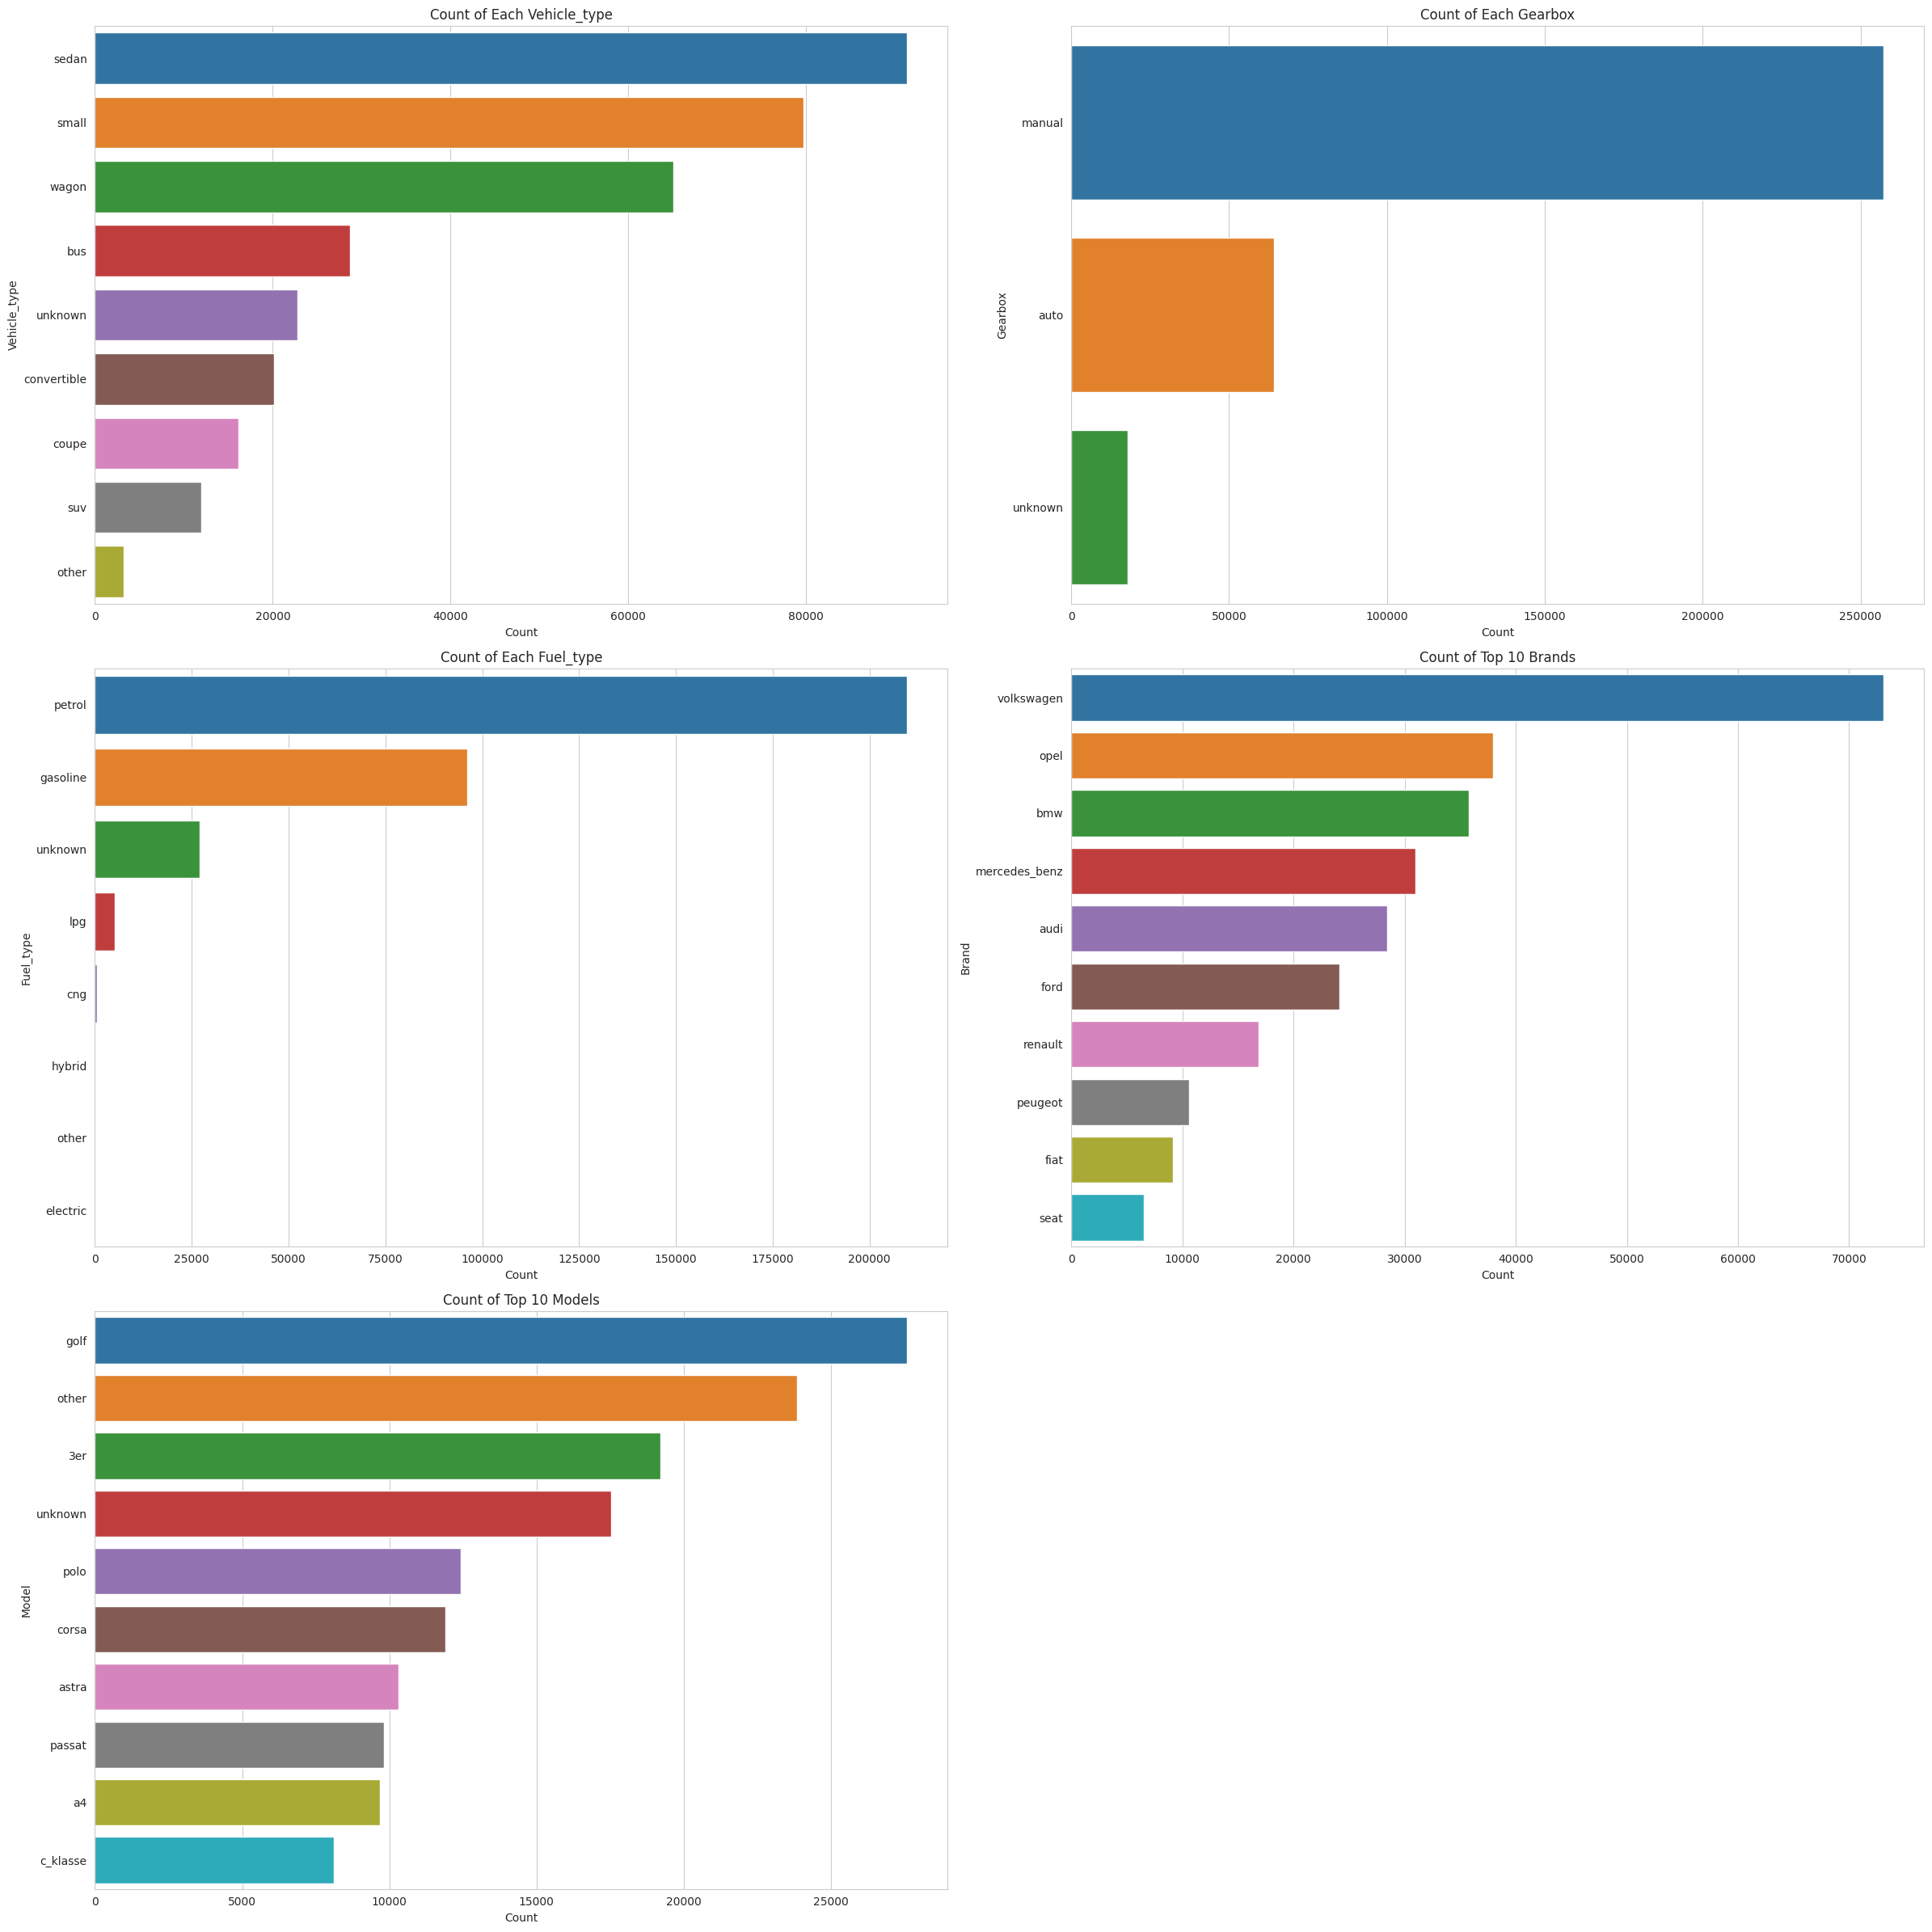

In [39]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the figure size for all count plots
plt.figure(figsize=(24, 24))

# List of other categorical columns to plot
other_categorical_columns = ['vehicle_type', 'gearbox', 'fuel_type']

# Generate count plots for each specified column
for i, column in enumerate(other_categorical_columns, 1):
    plt.subplot(3, 2, i)
    sns.countplot(y=df[column], order=df[column].value_counts().index[:10])
    plt.title(f'Count of Each {column.capitalize()}')
    plt.xlabel('Count')
    plt.ylabel(column.capitalize())

# Plot for the top 10 brands based on frequency
plt.subplot(3, 2, 4)
top_10_brands = df['brand'].value_counts().nlargest(10).index
sns.countplot(y=df['brand'], order=top_10_brands)
plt.title('Count of Top 10 Brands')
plt.xlabel('Count')
plt.ylabel('Brand')

# Plot for the top 10 models based on frequency
plt.subplot(3, 2, 5)
top_10_models = df['model'].value_counts().nlargest(10).index
sns.countplot(y=df['model'], order=top_10_models)
plt.title('Count of Top 10 Models')
plt.xlabel('Count')
plt.ylabel('Model')

# Adjust layout
plt.tight_layout()
plt.show()

## Categorical charts conclusions:


- Vehicle Type: Sedans and wagons are the most common body types, indicating a preference for these kinds of vehicles in the used car market.
- Gearbox: Manual transmissions significantly outnumber automatic ones, suggesting that manual vehicles are either more available or less preferred that they are being sold.
- Fuel Type: Petrol and diesel are the predominant fuel types, with petrol having a slight edge over diesel. Other fuel types like LPG, CNG, and hybrid are much less common.
- Brand: Volkswagen is the most common brand, followed by Opel and BMW, showing these brands' popularity or market prevalence.
- Model: Consequently, Golf, which is made by Volkswagen, has the highest frequency in the listings. The top models are likely to be from the most common brands, and they reflect the specific models that are popular or frequently sold in the used car market.

There are a lot of brands and models leading to graphs that are difficult to read and interpret, so I chose to only show the top 10 for each of them.

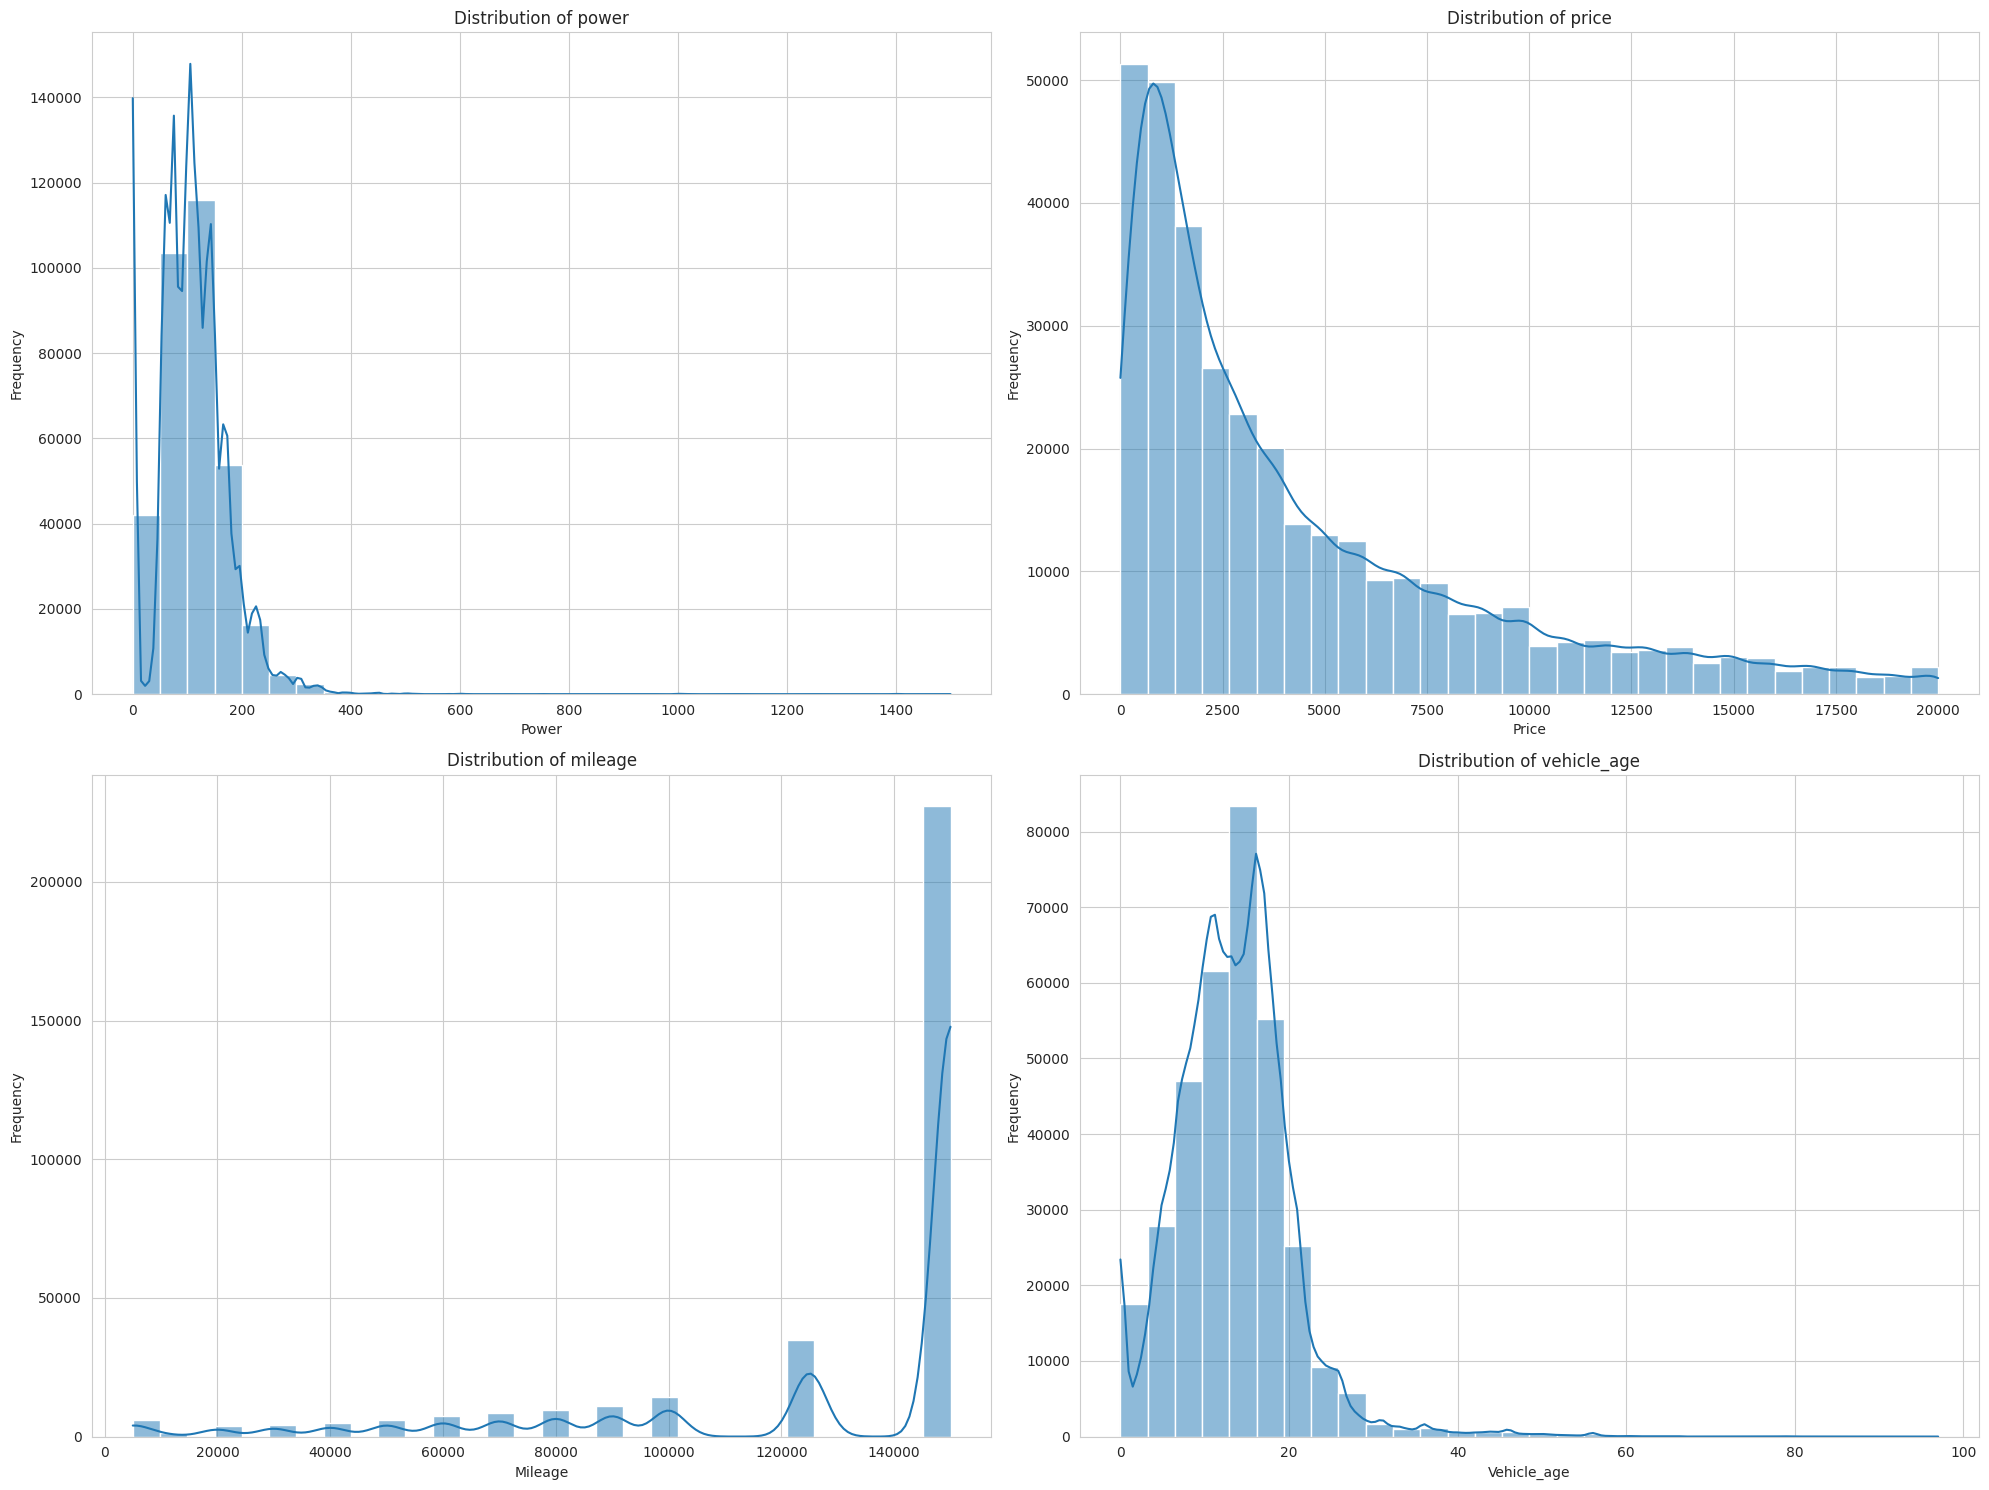

In [40]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the figure size for all histograms
plt.figure(figsize=(20, 15))

# List of columns to plot
columns_to_plot = ['power', 'price', 'mileage', 'vehicle_age']

# Generate histograms for each specified column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

## Numerical Charts Conclusions:

- **Power**: Most vehicles have power ratings clustered around a peak that appears to be just above the average, with a long tail extending to higher horsepower values, suggesting a few high-performance vehicles.
- **Price**: The distribution of the price shows that most used vehicles are priced at the lower end of the spectrum, with a quick drop-off as prices increase, which is typical in the used car market where lower-priced vehicles are more commonly sold.
- **Mileage**: There's a noticeable peak at the high end of the mileage spectrum, likely due to a large number of vehicles approaching a standard maximum mileage value before being sold or retired.
- **Vehicle Age**: The age of the vehicles shows a distribution that skews towards younger cars, with a peak before slowly tapering off as vehicle age increases.

The smooth line that follows the shape of the histogram is the Kernel Density Estimate. It's a way to estimate the probability density function of the variable. It provides a smooth curve that gives a sense of the shape of the distribution.

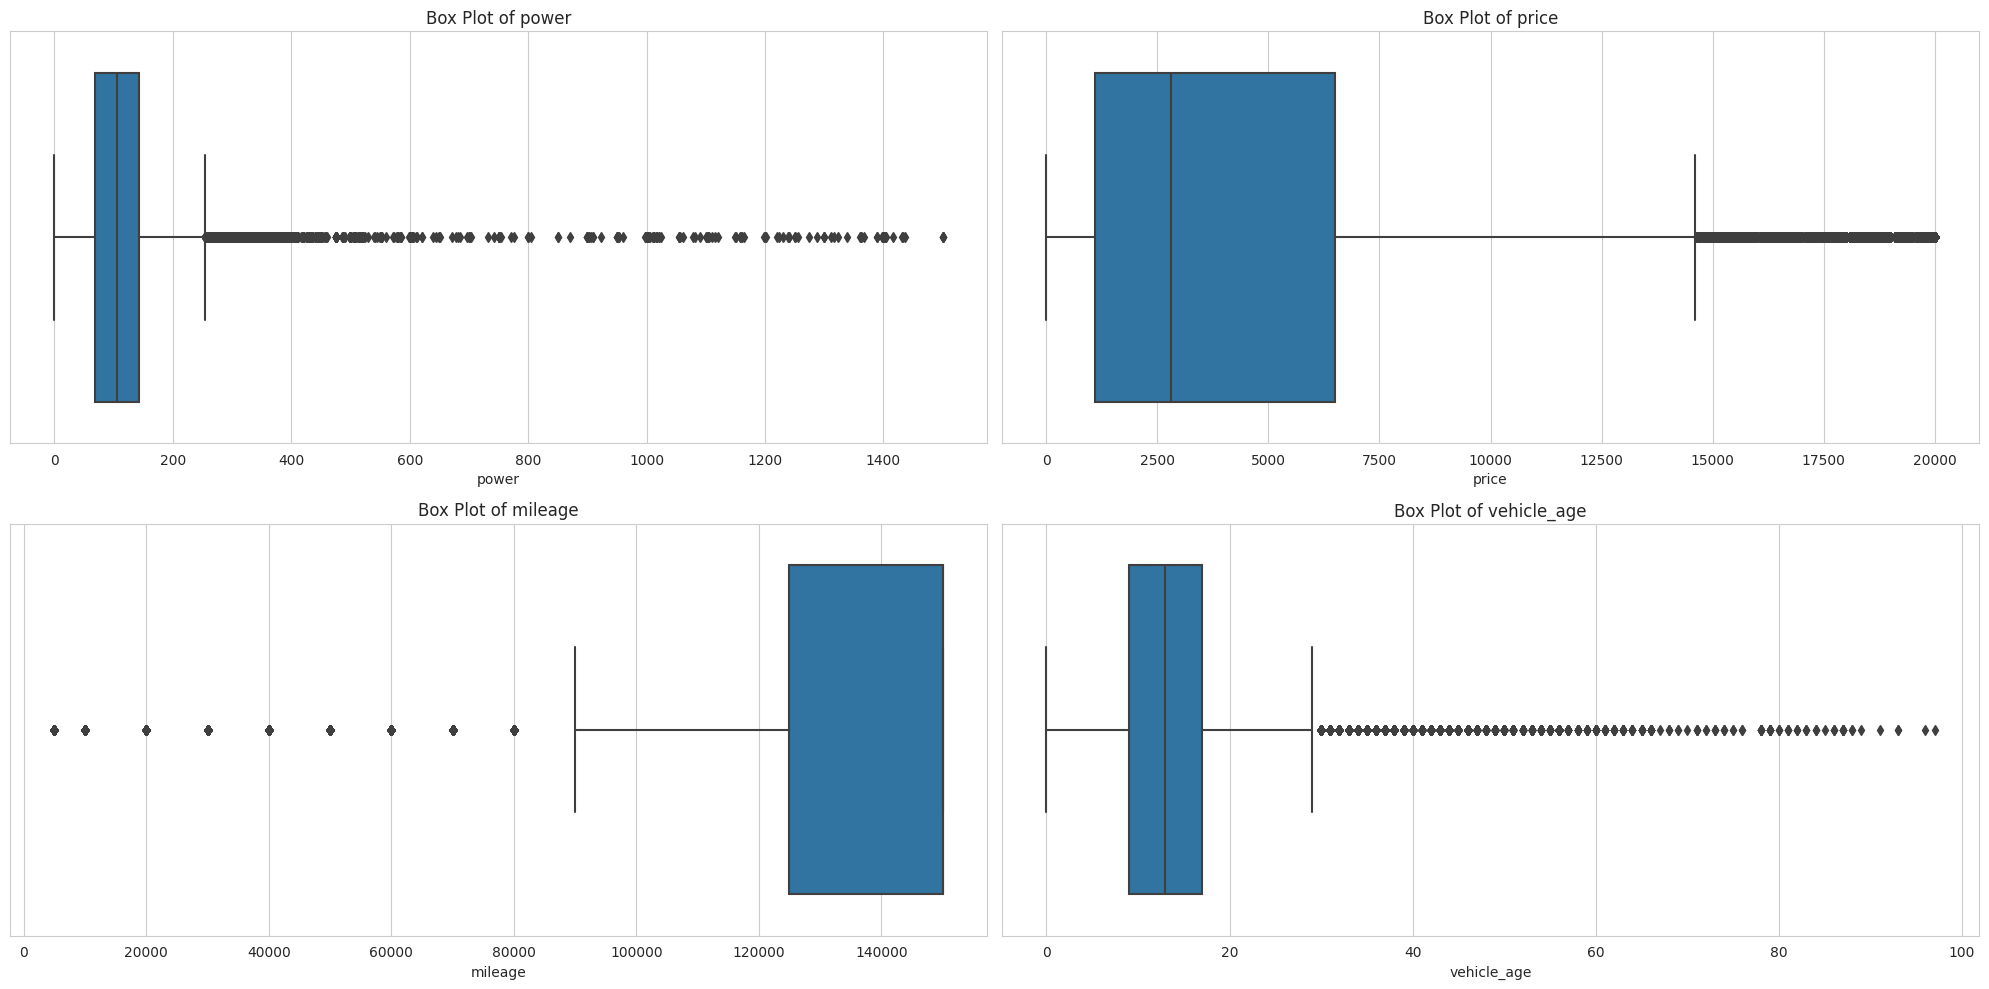

In [41]:
# Define the figure size for all box plots
plt.figure(figsize=(20, 10))

# Generate box plots for each specified column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')

# Show the plots
plt.tight_layout()
plt.show()

## Box Plots of Numerical Data:

- **Power:** There are outliers present beyond the upper whisker of the box plot for power, which are vehicles with exceptionally high horsepower.
- **Price:** The box plot for price exhibits a significant number of high-value outliers, reflecting a minority of vehicles that are priced much higher than the general trend.
- **Mileage:** The majority of the vehicles fall within a typical range of use.
- **Vehicle Age:** Vehicle age is well-clustered within a reasonable range, where most vehicles are under 30 years old.


The provided visualizations effectively capture the distribution and spread of both categorical and numerical variables, offering valuable insights into the used car market's dynamics. These insights can guide further analysis, such as identifying the factors that most significantly affect a vehicle's price or the popularity of certain vehicle types and models.

# Model training

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339224 entries, 0 to 339223
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        339224 non-null  datetime64[ns]
 1   price               339224 non-null  int64         
 2   vehicle_type        339224 non-null  object        
 3   registration_year   339224 non-null  int64         
 4   gearbox             339224 non-null  object        
 5   power               339224 non-null  int64         
 6   model               339224 non-null  object        
 7   mileage             339224 non-null  int64         
 8   registration_month  339224 non-null  int64         
 9   fuel_type           339224 non-null  object        
 10  brand               339224 non-null  object        
 11  not_repaired        339224 non-null  object        
 12  date_created        339224 non-null  datetime64[ns]
 13  number_of_pictures  339224 no

In [43]:
# Selecting columns important for modeling
selected_cols = [
    "price",
    "vehicle_type",
    "gearbox",
    "power",
    "model",
    "mileage",
    "fuel_type",
    "brand",
    "vehicle_age",
]
df = df[selected_cols]

In [44]:
# Assuming df is your DataFrame and it's already preprocessed
# Define the features and target variable
X = df.drop('price', axis=1)  # Feature matrix
y = df['price']               # Target variable

# Identify numerical and categorical columns
numerical_columns = ['power', 'mileage', 'vehicle_age']  # Assuming these are the only numerical columns
categorical_columns = [col for col in X.columns if col not in numerical_columns]

In [45]:
# Create the preprocessing pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

In [46]:
# Define a function to capture time and RMSE
def train_and_predict(pipeline, X_train, y_train, X_test, y_test):
    start_time = time()
    pipeline.fit(X_train, y_train)
    training_time = time() - start_time
    
    start_time = time()
    y_pred = pipeline.predict(X_test)
    prediction_time = time() - start_time
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    return rmse, training_time, prediction_time

In [47]:

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=234)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=234)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(203534, 8)
(67845, 8)
(67845, 8)


In [48]:
%%time
# Initialize results dictionary
results = {}

# List of models
pipelines = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=234))
    ]),
}


X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=234)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=234)


# Evaluate each model
for model_name, pipeline in pipelines.items():
    rmse, train_time, pred_time = train_and_predict(pipeline, X_train, y_train, X_valid, y_valid)
    results[model_name] = [rmse, train_time, pred_time]

# Convert results to a DataFrame for display
df_results = pd.DataFrame(results, index=['RMSE', 'Training Time (s)', 'Prediction Time (s)']).T

# Display the consolidated results
display(df_results)

,RMSE,Training Time (s),Prediction Time (s)
Random Forest,2043.133641,101.350053,0.27508


CPU times: user 1min 41s, sys: 41.5 ms, total: 1min 41s
Wall time: 1min 41s


In [49]:
%%time
# Initialize results dictionary
results = {}

# List of models
pipelines = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=234))
    ]),
}



# Evaluate each model
for model_name, pipeline in pipelines.items():
    rmse, train_time, pred_time = train_and_predict(pipeline, X_train_valid, y_train_valid, X_test, y_test)
    results[model_name] = [rmse, train_time, pred_time]

# Convert results to a DataFrame for display
df_results = pd.DataFrame(results, index=['RMSE', 'Training Time (s)', 'Prediction Time (s)']).T

# Display the consolidated results
display(df_results)

,RMSE,Training Time (s),Prediction Time (s)
Random Forest,2022.266035,137.400439,0.273647


CPU times: user 2min 17s, sys: 34.9 ms, total: 2min 17s
Wall time: 2min 17s


In [54]:
%%time
# Initialize results dictionary
results = {}

# List of models
pipelines = {

    "Linear Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('reg
ressor', LinearRegression())
    ]),
    
"Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=234))

    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(max_depth=20, random_state=234))
    ]),
    "LightGBM": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', lgb.LGBMRegressor(n_estimators=50, max_depth=10, num_leaves=32)) 
    ]),
    "CatBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(iterations=500, depth=10, verbose=0, random_state=234))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(n_estimators=50, max_depth=10, random_state=234, verbosity=0))
    ])
}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=234)


# Evaluate each model
for model_name, pipeline in pipelines.items():
    rmse, train_time, pred_time = train_and_predict(pipeline, X_train, y_train, X_test, y_test)
    results[model_name] = [rmse, train_time, pred_time]

# Convert results to a DataFrame for display
df_results = pd.DataFrame(results, index=['RMSE', 'Training Time (s)', 'Prediction Time (s)']).T

# Display the consolidated results
display(df_results)

The evaluation shows that CatBoost achieved the lowest RMSE, indicating the best predictive accuracy among the tested models, followed closely by XGBoost and LightGBM. Although Random Forest and Decision Tree models performed reasonably well, they were not as effective as the gradient boosting models. Linear Regression had the highest RMSE, serving as a baseline for comparison. LightGBM offered the fastest training time, showcasing its efficiency. This analysis highlights the effectiveness of gradient boosting models in handling this dataset, with CatBoost leading in accuracy and LightGBM in speed.

# Conclusion


This project's comprehensive evaluation of various models for predicting used car prices highlights the effectiveness of gradient boosting models, particularly CatBoost, which demonstrated superior accuracy. LightGBM's remarkable training efficiency underscores the potential for optimizing speed without significantly compromising predictive quality. The analysis, supported by robust preprocessing and a methodical approach to model selection and evaluation, illustrates the nuanced trade-offs between accuracy, training time, and prediction speed. This project serves as a foundational step towards developing a predictive tool for Rusty Bargain's app, guiding users in estimating car values swiftly and accurately.